In [1]:
from utils import *
from dataset import *
from autoencoder import *

Ashley = False
if Ashley:
    device = "cpu"
else:
    device = "cuda"

# Load data from pickle

In [56]:
import pickle

# # Specify the file name
file_name = '../Chandra_data/large_eventfiles_lifetime28800.pkl'

# # Load and deserialize the list from the file
# with open(file_name, 'wb') as file:  # Note the 'wb' mode for writing bytes
#     pickle.dump(data_lst, file)
    
with open(file_name, 'rb') as file: 
    data_lst = pickle.load(file)

In [57]:
# Record special labels
B = 64
data = RealEventsDataset(data_lst,E_bins=3,t_scale=28800)
loader = DataLoader(data, batch_size=B, shuffle=True, num_workers=4, collate_fn=padding_collate_fn)

In [58]:
# Create and save NN model
num_freqs = 12
num_latent = 30
E_bins = 3
encoding = PositionalEncoding(num_freqs=num_freqs,include_input=True)

import json
checkpoint = '../experiments/large_TVtotalrate_E3_decoder_lamTV0004_B16_lr1e-3'
with open(f'{checkpoint}/arguments.json', 'r') as file:
    opt = json.load(file)
class DotDict:
    def __init__(self, dictionary):
        for key, value in dictionary.items():
            if isinstance(value, dict):
                value = DotDict(value)
            self.__dict__[key] = value
opt = DotDict(opt)

model = AutoEncoder.load_from_checkpoint(f'{checkpoint}/model_80epochs.ckpt',latent_num=len(data),
                                          model_type=opt.model_type, latent_size=opt.num_latent, encoding=encoding,
                                          hidden_size=opt.hidden_size, E_bins=opt.E_bins, lam_TV=opt.lam_TV, 
                                           lam_latent=opt.lam_latent, d_encoder_model=opt.d_transformer_token,
                                           nhead=opt.n_transformer_head,num_encoder_layers=opt.n_encoder_layers,
                                           dim_feedforward=opt.d_encoder_forward, lr=opt.lr)
model.to(device);

In [59]:
# Test data, currently just the training data
test_loader = DataLoader(data, batch_size=B, collate_fn=padding_collate_fn)
outputs = []
for idx, batch in enumerate(test_loader):
    temp = idx * B
    if temp % 4096 == 0:
        print(temp)
    batch = todevice(batch, device)
    batch = model(batch)
    outputs.append(todevice(batch,'cpu'))

def output_collate_fn(outputs):
    '''
    Outputs is a list of dic
    '''
    output = {}
    for key in outputs[0].keys():
        if key in ['latent','T','num_events','class','hard_hm','hard_hs','hard_ms','var_prob_b','var_prob_s','var_prob_m','var_prob_h','var_index_b']:
            output[key] = torch.cat([o[key] for o in outputs], dim=0)
        # elif key == 'class':
        #     output[key] = sum([o[key] for o in outputs],[])
        else:
            output[key] = [o[key] for o in outputs]
    return output

collated_outputs = output_collate_fn(outputs)
collated_outputs['num_events_per'] = collated_outputs['num_events'] / collated_outputs['T']

0
4096
8192
12288
16384
20480
24576
28672
32768
36864
40960
45056
49152
53248
57344
61440
65536
69632
73728
77824
81920
86016
90112
94208
98304
102400
106496


In [9]:
# outputs[0].keys()

dict_keys(['id', 'event_list', 'hard_hm', 'hard_ms', 'hard_hs', 'var_prob_b', 'var_index_b', 'var_prob_s', 'var_prob_m', 'var_prob_h', 'event_list_len', 'idx', 'mask', 'latent', 'rates', 'total_rates', 'total_list', 'T', 'num_events', 'total_mask'])

In [6]:
import pickle

# # Specify the file name
file_name = '../Chandra_data/large_eventfiles_filtered_lifetime28800_latents.pkl'

# # Load and deserialize the list from the file
# with open(file_name, 'wb') as file:  # Note the 'wb' mode for writing bytes
#     pickle.dump(collated_outputs, file)
    
with open(file_name, 'rb') as file: 
    collated_outputs = pickle.load(file)

# PCA

In [43]:
# Continuous metric
##### PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
z = collated_outputs['latent']
embedding = pca.fit_transform(z)

# Define binary color map
colors = ['red', 'blue']  # Choose colors that suit your preference
labels = ['false_flares', 'true_flares']  # Replace with meaningful group names
################## Discrete metrics
# for group in [0, 1]:
#     idx = (collated_outputs[metric] == group)
#     plt.scatter(embedding[idx, 0], embedding[idx, 1], c=colors[group], label=labels[group], 
#                 alpha=0.7, marker='o', s=3)
    
# N = 729
# special_labels = ['flare1_first','flare1_second',
#                  'flare2_first','flare2_second',
#                  'nonflare1_first','nonflare1_second',
#                  'nonflare2_first','nonflare2_second']
# for i, l in enumerate(special_labels):
#     x, y = embedding[i+N, :]
#     plt.annotate(l, (x, y), textcoords="offset points", xytext=(0,0), ha='center',color='black', fontsize=12)
# plt.savefig(f'../plots/movingwindow_PCA_{metric}.png')




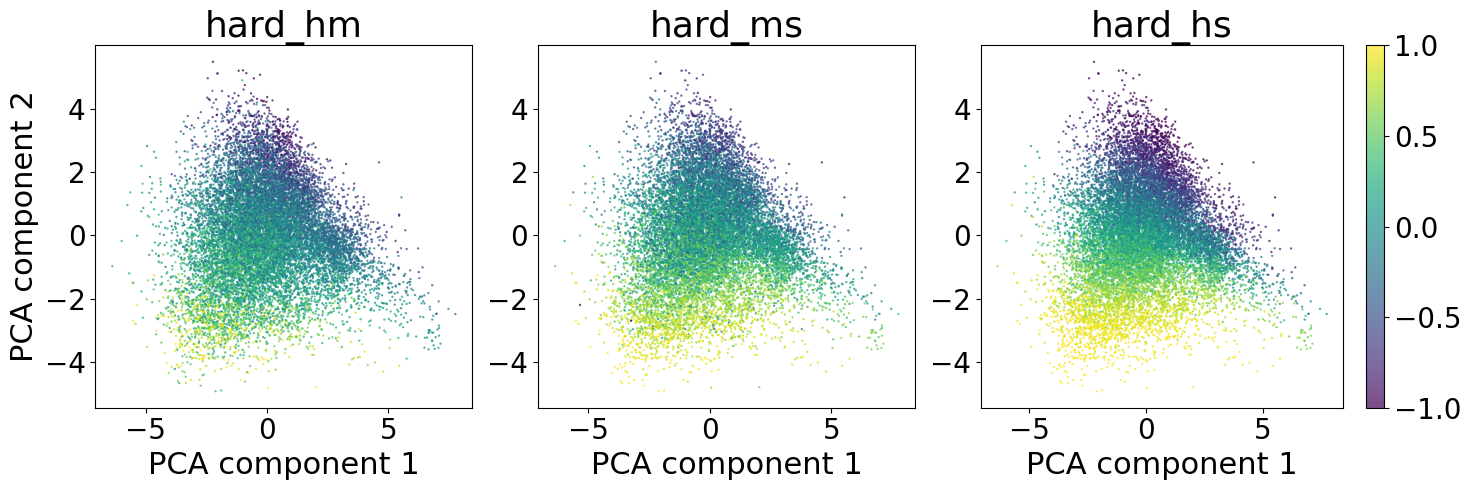

In [44]:
# Continuous metrics
title_size = 26
label_size = 22
tick_size = 20
fig, axes = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1, 1.2]})
metrics = ['hard_hm','hard_ms','hard_hs']
# metrics = ['var_index_b','var_prob_b','var_prob_h']
for i, ax in enumerate(axes):
    metric = metrics[i]
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=collated_outputs[metric], cmap='viridis', alpha=0.7, 
                marker='o',s=0.5, vmin=min(collated_outputs[metric]), vmax=max(collated_outputs[metric]))
    ax.set_xlabel('PCA component 1',size=label_size)
    if i == 0:
        ax.set_ylabel('PCA component 2',size=label_size)
    if i == 2:
        cbar = plt.colorbar(scatter)
        cbar.ax.tick_params(labelsize=tick_size)
    ax.set_title(metric,size=title_size)
    ax.tick_params(axis='both', which='major', labelsize=tick_size)
plt.subplots_adjust(right=0.8)
plt.tight_layout()
# plt.savefig(f'../plots/draft_PCA.pdf')

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:10                                                                                   │
│                                                                                                  │
│    7 metrics = ['var_index_b','var_prob_b','var_prob_h']                                         │
│    8 for i, ax in enumerate(axes):                                                               │
│    9 │   metric = metrics[i]                                                                     │
│ ❱ 10 │   scatter = ax.scatter(z[:, 0], z[:, 1], c=collated_outputs[metric], cmap='viridis', a    │
│   11 │   │   │   │   marker='o',s=0.5, vmin=min(collated_outputs[metric]), vmax=max(collated_    │
│   12 │   ax.set_xlabel('Dimension 1',size=label_size)                                            │
│   13 │   if i == 0:                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'z' is not defined

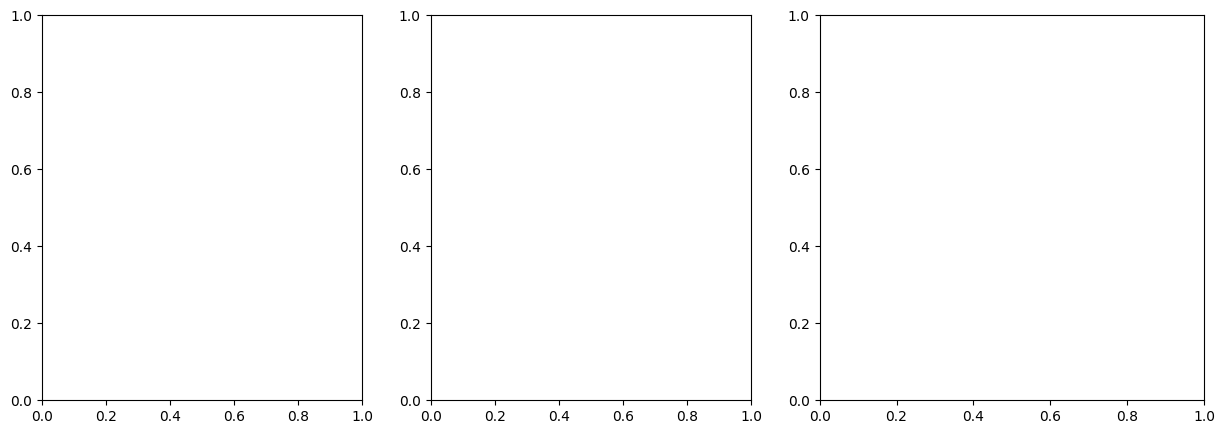

In [3]:
# Continuous metrics
title_size = 26
label_size = 22
tick_size = 20
fig, axes = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1, 1.2]})
# metrics = ['hard_hm','hard_ms','hard_hs']
metrics = ['var_index_b','var_prob_b','var_prob_h']
for i, ax in enumerate(axes):
    metric = metrics[i]
    scatter = ax.scatter(z[:, 0], z[:, 1], c=collated_outputs[metric], cmap='viridis', alpha=0.7, 
                marker='o',s=0.5, vmin=min(collated_outputs[metric]), vmax=max(collated_outputs[metric]))
    ax.set_xlabel('Dimension 1',size=label_size)
    if i == 0:
        ax.set_ylabel('Dimension 2',size=label_size)
    if i == 2:
        cbar = plt.colorbar(scatter)
        cbar.ax.tick_params(labelsize=tick_size)
    ax.set_title(metric,size=title_size)
    ax.tick_params(axis='both', which='major', labelsize=tick_size)
plt.subplots_adjust(right=0.8)
plt.tight_layout()
plt.savefig(f'../plots/draft_PCA.pdf')

In [49]:
z[:,2].min()

tensor(-0.0003)

# Test PCA

In [7]:
# Continuous metric
##### PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
z = collated_outputs['latent']
# embedding = pca.fit_transform(z)

# Define binary color map
colors = ['red', 'blue']  # Choose colors that suit your preference
labels = ['false_flares', 'true_flares']  # Replace with meaningful group names

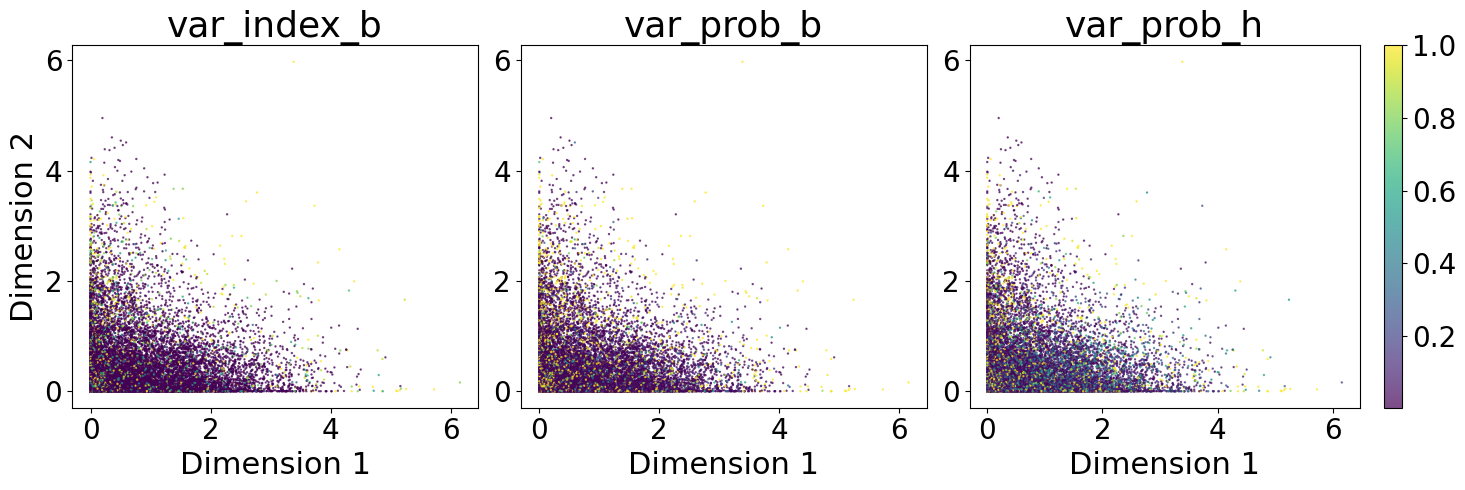

In [11]:
# Continuous metrics
title_size = 26
label_size = 22
tick_size = 20
fig, axes = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1, 1.2]})
# metrics = ['hard_hm','hard_ms','hard_hs']
metrics = ['var_index_b','var_prob_b','var_prob_h']
for i, ax in enumerate(axes):
    metric = metrics[i]
    scatter = ax.scatter(z[:, 0], z[:, 1], c=collated_outputs[metric], cmap='viridis', alpha=0.7, 
                marker='o',s=0.5, vmin=min(collated_outputs[metric]), vmax=max(collated_outputs[metric]))
    ax.set_xlabel('Dimension 1',size=label_size)
    if i == 0:
        ax.set_ylabel('Dimension 2',size=label_size)
    if i == 2:
        cbar = plt.colorbar(scatter)
        cbar.ax.tick_params(labelsize=tick_size)
    ax.set_title(metric,size=title_size)
    ax.tick_params(axis='both', which='major', labelsize=tick_size)
plt.subplots_adjust(right=0.8)
plt.tight_layout()
plt.savefig(f'../plots/bug.png')

In [66]:
max(z[:,0])

tensor(8.8997)

In [52]:
from bhtsne import tsne
data_nd_tsne = tsne(z.numpy().astype(np.float64))

############## Classes
# for group in [0,1]:
#     idx = labels == group
#     plt.scatter(data_nd_tsne[idx, 0], data_nd_tsne[idx, 1], color=colors[group], label=names[group], marker='o',s=3)
    
# N = 729
# special_labels = ['flare1_first','flare1_second',
#                  'flare2_first','flare2_second',
#                  'nonflare1_first','nonflare1_second',
#                  'nonflare2_first','nonflare2_second']
# for i, l in enumerate(special_labels):
#     x, y = data_nd_tsne[i+N, :]
#     plt.annotate(l, (x, y), textcoords="offset points", xytext=(0,0), ha='center',color='black', fontsize=12)
    


Using current time as random seed...
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 0 of 14891
 - point 10000 of 14891
Input similarities computed in 17.48 seconds (sparsity = 0.009720)!
Learning embedding...
Iteration 50: error is 100.254158 (50 iterations in 9.96 seconds)
Iteration 100: error is 100.059358 (50 iterations in 10.50 seconds)
Iteration 150: error is 98.180041 (50 iterations in 10.66 seconds)
Iteration 200: error is 97.712943 (50 iterations in 10.79 seconds)
Iteration 250: error is 5.653928 (50 iterations in 11.22 seconds)
Iteration 300: error is 4.121264 (50 iterations in 8.17 seconds)
Iteration 350: error is 3.913233 (50 iterations in 7.99 seconds)
Iteration 400: error is 3.795529 (50 iterations in 8.07 seconds)
Iteration 450: error is 3.713297 (50 iterations in 8.11 seconds)
Iteration 500: error is 3.651224 (50 iterations in 8.13 seconds)
Iteration 550: error is 3.601644 (50 iterations in 8.16 s

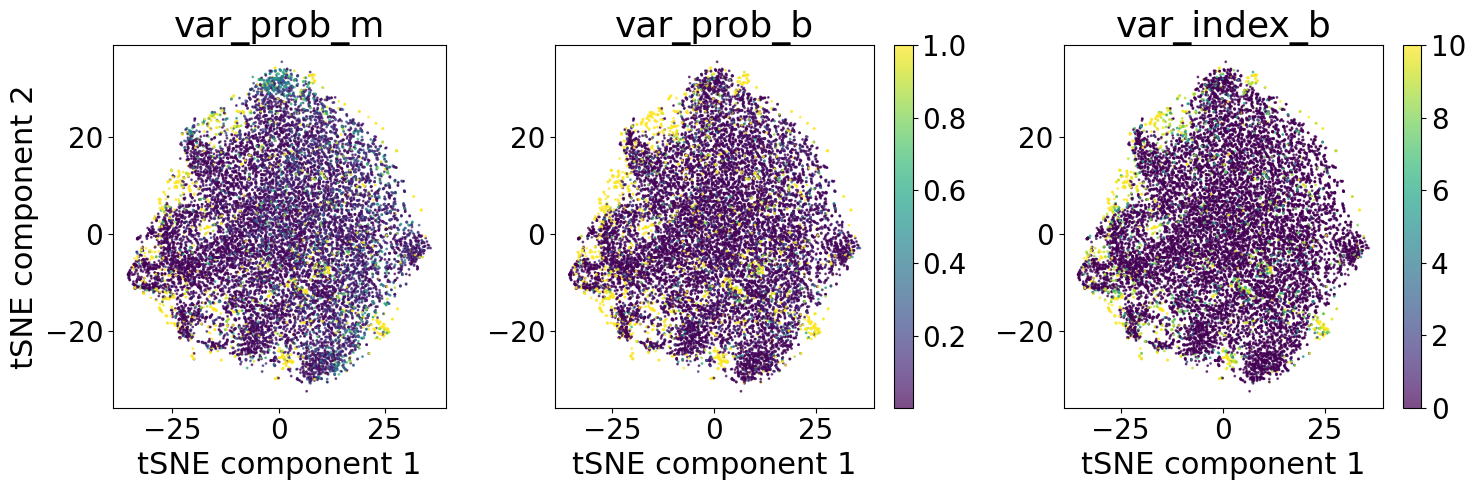

In [53]:
# labels = collated_outputs['class'].numpy()

# colors = ['red', 'blue']  # Choose colors that suit your preference
# names = ['false_flares', 'true_flares']  # Replace with meaningful group names

fig, axes = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1.2, 1.2]})
# metrics = ['hard_hm','hard_ms','hard_hs']
metrics = ['var_prob_m','var_prob_b','var_index_b']
for i, ax in enumerate(axes):
    metric = metrics[i]
    scatter = ax.scatter(data_nd_tsne[:, 0], data_nd_tsne[:, 1], c=collated_outputs[metric], cmap='viridis', alpha=0.7, 
            marker='o',s=1, vmin=min(collated_outputs[metric]), vmax=max(collated_outputs[metric]))
    ax.set_xlabel('tSNE component 1',size=label_size)
    if i == 0:
        ax.set_ylabel('tSNE component 2',size=label_size)
    if i >0:
        cbar = plt.colorbar(scatter)
        cbar.ax.tick_params(labelsize=tick_size)
    ax.set_title(metric,size=title_size)
    ax.tick_params(axis='both', which='major', labelsize=tick_size)
plt.subplots_adjust(right=0.8)
plt.tight_layout()
plt.savefig(f'../plots/poster_tSNE.pdf')

## Single dimension visualization

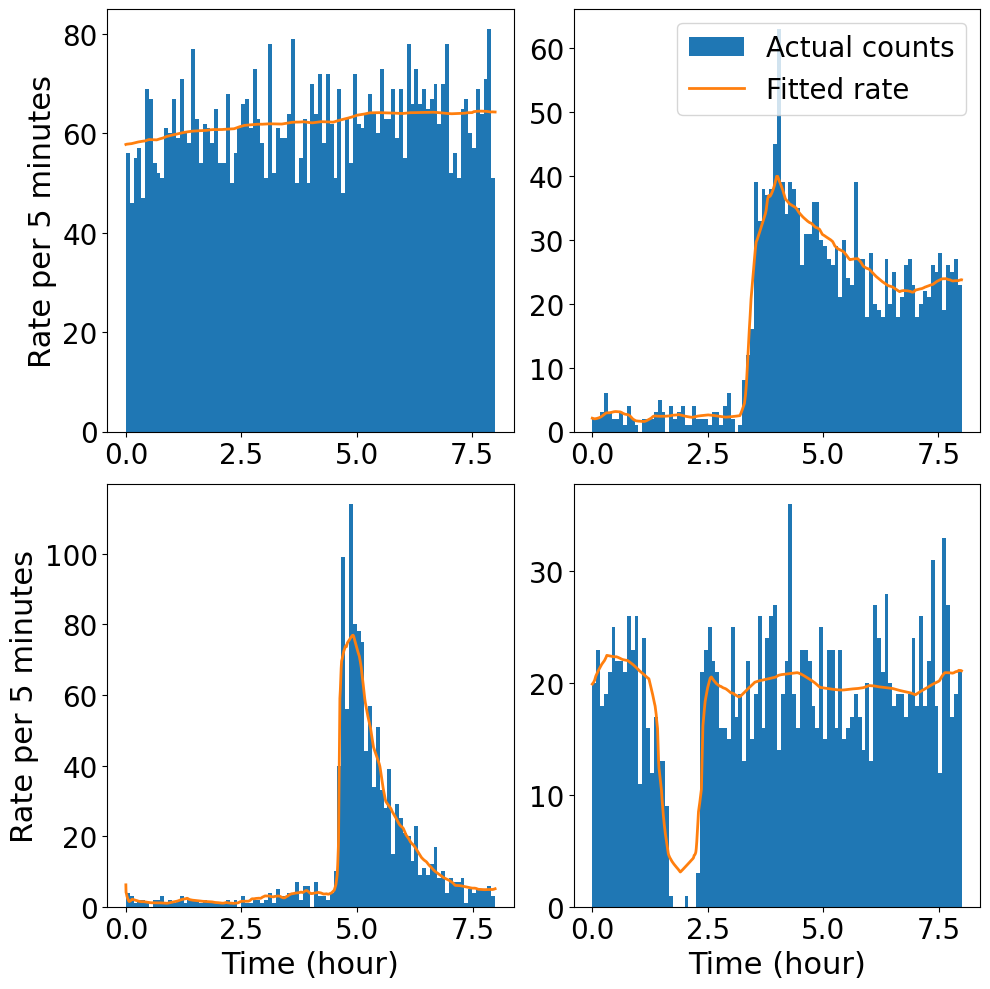

In [54]:
nbins = 96
t_scale = 28800
# Plot total rates
batch_indices = [1,41,44,77]
start_indices = [0,0]
E_index = 0

k = 4
fig, axes = plt.subplots(2, 2, figsize=(10,10))

for i in range(k):
    batch_index = batch_indices[i]
    # index = start_indices[i]
    index = 0

    batch = outputs[batch_index]
    mask = batch['mask'][index]
    times = batch['event_list'][index,mask,0] * t_scale / 3600

    
    total_mask = batch['total_mask'][index]
    total_times = batch['total_list'][index,total_mask,0] * t_scale / 3600
    rates = batch['total_rates'][index,total_mask] * 28800 / t_scale / nbins
    
    T = batch['T'][index] * t_scale
    axes[i//2,i%2].hist(times, bins = nbins,label='Actual counts')
    axes[i//2,i%2].plot(total_times, torch.sum(rates,dim=-1),label='Fitted rate',linewidth=2)
    axes[i//2,i%2].tick_params(axis='both', which='major', labelsize=tick_size)
    if i % 2==0:
        axes[i//2,i%2].set_ylabel('Rate per 5 minutes',size=label_size)
    if i // 2 == 1:
        axes[i//2,i%2].set_xlabel('Time (hour)',size=label_size)
    if i == 1:
        axes[i//2, i%2].legend(fontsize=tick_size,loc='upper right')

plt.tight_layout()
plt.savefig('../plots/poster_reconstruction.pdf')
plt.show()




In [ ]:
# # Plot rates for a specific energy bin
# plt.figure(figsize=(12,9))
# batch_index = 0
# start_index = 0
# E_index = 1
# for i in range(16):
#     index = start_index + i
#     batch = outputs[batch_index]
#     mask = batch['mask'][index]
#     times = batch['event_list'][index,mask,:]
#     E_mask = times[:,E_index+1]==1
#     times = times[E_mask,0] * plotting_t_scale
#     rates = batch['rates'][index,mask,E_index]
#     rates = rates[E_mask] / plotting_t_scale
#     T = batch['T'][index] * plotting_t_scale
    
#     plt.subplot(4,4,i+1)
#     plt.hist(times, bins = torch.arange(torch.ceil(T)))
#     plt.plot(times, rates)
# plt.suptitle(f'Fitted vs true total rates for energy bin {E_index+1}',size=20)
# plt.tight_layout()
# plt.savefig(f'../plots/total_rate_comparison_E{E_index+1}.png')
# plt.show()